In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
from PIL import Image

## 0. Downloading the data and taking a look at it

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [3]:
img = plt.imread(path/'train/n01440764/n01440764_13464.JPEG')

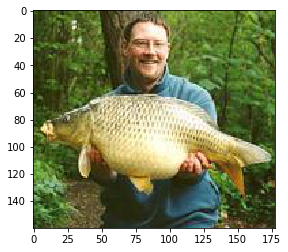

In [6]:
plt.imshow(img)

## 1. Creating the Datasets and Dataloaders

In [7]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [8]:
files = getListOfFiles(str(path))

In [9]:
idx =  random.sample(range(0, len(files)), int(len(files)*0.2))

files_series = pd.Series(files)

files_val = list(files_series.loc[idx])
files_train = list(files_series.drop(idx))

In [27]:
class CustomDataset(Dataset):
    def __init__(self, files, window_size=30, tfms=None):
        self.files = files
        self.window_size=window_size
        self.tfms = tfms
        
    def __len__(self): return len(self.files)
        
    def show(self,idx):
        sample = self.__getitem__(idx)
        #fig=plt.figure(figsize=(5, 5))
        f, ax = plt.subplots(1,2)
        #import pdb;pdb.set_trace()
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        x = (sample[0].numpy().transpose((1,2,0))*stds + means)*255
        y = (sample[1].numpy().transpose((1,2,0))*stds + means)*255
        ax[0].imshow(x.astype(np.uint8))
        ax[1].imshow(y.astype(np.uint8))    
        
            
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #import pdb;pdb.set_trace()
        img = io.imread(self.files[idx])
        if len(img.shape) < 3:
            aux = np.zeros(shape=(160,160,3))
            aux[:,:,0] = img
            aux[:,:,1] = img
            aux[:,:,2] = img
            img = aux

        #import pdb;pdb.set_trace()
        #img = img.transpose((2,0,1))
        #img = torch.from_numpy(img)
        
        if self.tfms: 
            #import pdb;pdb.set_trace()
            img = self.tfms(Image.fromarray(img))
        #import pdb;pdb.set_trace()

        
        row_init = np.random.randint(0,img.shape[1]-self.window_size)
        col_init = np.random.randint(0,img.shape[2]-self.window_size)
        #import pdb;pdb.set_trace()
        target = img[:,row_init:row_init+self.window_size,col_init:col_init+self.window_size]
        img_window = img.clone()
        img_window[0,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.485)/0.229
        img_window[1,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.456)/0.224
        img_window[2,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.406)/0.225


        sample = (img_window,img)
        
        return sample

In [28]:
tfms_train = transforms.Compose([
        transforms.RandomResizedCrop(160,scale=(0.8,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.75,1.25), contrast=(0.75,1.25), saturation=(0.5,1.25)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [29]:
tfms_valid = transforms.Compose([
        transforms.RandomResizedCrop(160,scale=(0.8,1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [30]:
train_ds = CustomDataset(files_train,tfms=tfms_train,window_size=32)
valid_ds = CustomDataset(files_val,tfms=tfms_valid,window_size=32)

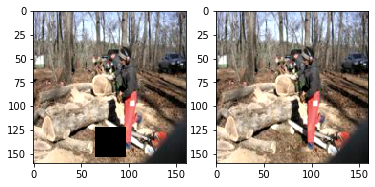

In [32]:
train_ds.show(0)

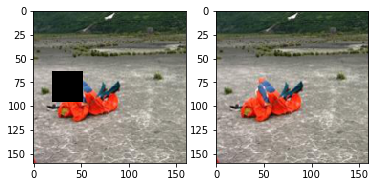

In [36]:
valid_ds.show(0)

In [37]:
train_dl = DataLoader(train_ds, batch_size=32,shuffle=True,num_workers=2)
valid_dl = DataLoader(train_ds, batch_size=32,shuffle=True,num_workers=2)

In [38]:
inputs, classes = next(iter(train_dl))

In [39]:
inputs.shape, classes.shape

(torch.Size([32, 3, 160, 160]), torch.Size([32, 3, 160, 160]))

## 2. Creating the model

In [40]:
mdl = models.resnet34(pretrained=True)

In [41]:
encoder = nn.Sequential(*list(mdl.children())[:-2])

In [42]:
c = encoder(inputs)
c.shape

torch.Size([32, 512, 5, 5])

In [43]:
#Putting a decoder on top of my encoder
fillNet = DynamicUnet(encoder, 3, img_size=(160,160),self_attention=True)

In [ ]:
bla = fillNet(inputs)
bla.shape

## 3. Creating the Databunch and Learner

In [0]:
data = DataBunch(train_dl,valid_dl)

In [0]:
learn = Learner(data, fillNet, loss_func=nn.MSELoss(), metrics = [psnr], callback_fns=ShowGraph)

In [0]:
#creating the layer groups so that I can use discriminative learning rates
learn.split([learn.model.layers[:2], 
             learn.model.layers[2:4], 
             learn.model.layers[4:6],
             learn.model.layers[6:8],
             learn.model.layers[8:10],
             learn.model.layers[10:]])

In [0]:
#first, fit only the decoder
for child in learn.model[0].children():
    for params in child.parameters():
        params.requires_grad = False

for child in learn.model[1].children():
    for params in child.parameters():
        params.requires_grad = False

In [39]:
learn.lr_find()

epoch,train_loss,valid_loss,psnr,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


TypeError: ignored

Min numerical gradient: 9.12E-04
Min loss divided by 10: 4.47E-01


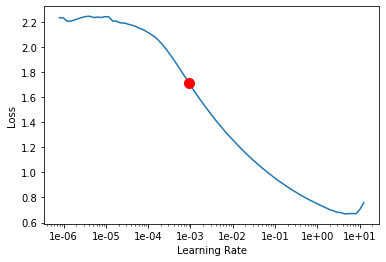

In [53]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,psnr,time
0,1.576904,0.729265,1.374689,00:11
1,0.881068,0.962901,0.176417,00:11
2,0.526705,0.205730,6.870190,00:11
3,0.347725,0.141034,8.509629,00:11
4,0.247704,0.114547,9.412646,00:11
5,0.181615,0.088630,10.527309,00:11
6,0.140881,0.064372,11.922674,00:11
7,0.111194,0.057775,12.389889,00:11
8,0.089996,0.047680,13.220981,00:11
9,0.074482,0.042027,13.769134,00:11


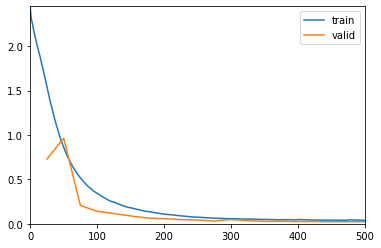

Better model found at epoch 0 with valid_loss value: 0.7292649745941162.
Better model found at epoch 2 with valid_loss value: 0.20572985708713531.
Better model found at epoch 3 with valid_loss value: 0.14103443920612335.
Better model found at epoch 4 with valid_loss value: 0.11454697698354721.
Better model found at epoch 5 with valid_loss value: 0.0886303186416626.
Better model found at epoch 6 with valid_loss value: 0.06437216699123383.
Better model found at epoch 7 with valid_loss value: 0.057774659246206284.
Better model found at epoch 8 with valid_loss value: 0.04767997935414314.
Better model found at epoch 9 with valid_loss value: 0.04202704504132271.
Better model found at epoch 10 with valid_loss value: 0.03198479115962982.
Better model found at epoch 13 with valid_loss value: 0.02746543101966381.
Better model found at epoch 14 with valid_loss value: 0.027108216658234596.
Better model found at epoch 15 with valid_loss value: 0.025542398914694786.
Better model found at epoch 16 wi

In [54]:
learn.fit_one_cycle(20, max_lr=9.12e-4,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')],)

In [0]:
def show_results(learn,figsize=(5,5)):
    inputs,classes = next(iter(learn.data.valid_dl))
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    inp = (inputs[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (classes[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    pred = (preds[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255

    mse = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1]*pred.shape[2])
    psnr = 10*np.log10(255/mse)

    print('MSE:',mse)
    print('PSNR:', psnr)

    #import pdb;pdb.set_trace()

    fig = plt.figure(figsize=figsize)
    ax0 = fig.add_subplot(131)
    ax0.imshow(inp.astype(np.uint8))
    ax0.title.set_text('Input')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

In [0]:
learn.load('stage-1')

MSE: 39.5703512809395
PSNR: 8.091702747548252


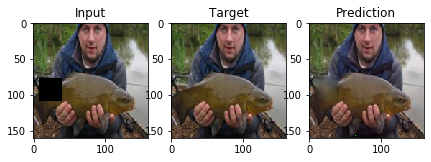

In [65]:
show_results(learn,figsize=(7,7))

In [0]:
#unfreezing the encoder
for child in learn.model[0].children():
    for params in child.parameters():
        params.requires_grad = True

for child in learn.model[1].children():
    for params in child.parameters():
        params.requires_grad = True

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


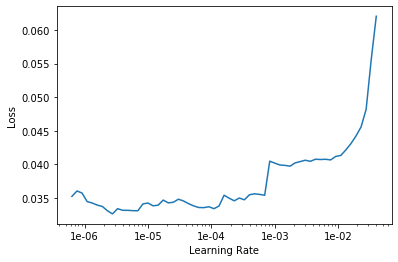

In [67]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,psnr,time
0,0.044757,0.027971,15.546079,00:12
1,0.039319,0.023937,16.230097,00:12
2,0.042742,0.022185,16.564140,00:12
3,0.040820,0.026374,15.804063,00:12
4,0.039957,0.022314,16.537565,00:12
5,0.039149,0.025812,15.891680,00:12
6,0.038333,0.026793,15.729558,00:12
7,0.042841,0.022976,16.395359,00:12
8,0.050010,0.034496,14.629028,00:12
9,0.044572,0.023757,16.266146,00:12


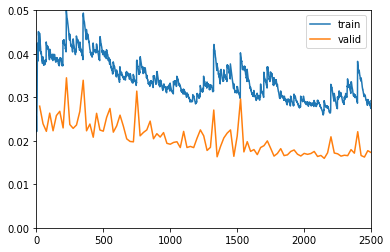

Better model found at epoch 0 with valid_loss value: 0.027971314266324043.
Better model found at epoch 1 with valid_loss value: 0.02393704280257225.
Better model found at epoch 2 with valid_loss value: 0.022185470908880234.
Better model found at epoch 16 with valid_loss value: 0.02083595097064972.
Better model found at epoch 26 with valid_loss value: 0.02045823633670807.
Better model found at epoch 27 with valid_loss value: 0.019857356324791908.
Better model found at epoch 28 with valid_loss value: 0.01977337710559368.
Better model found at epoch 38 with valid_loss value: 0.019428594037890434.
Better model found at epoch 39 with valid_loss value: 0.01922133006155491.
Better model found at epoch 42 with valid_loss value: 0.01845615915954113.
Better model found at epoch 46 with valid_loss value: 0.01844741962850094.
Better model found at epoch 50 with valid_loss value: 0.01778801530599594.
Better model found at epoch 53 with valid_loss value: 0.01633637212216854.
Better model found at ep

In [68]:
learn.fit_one_cycle(100, slice(1e-6,1e-4),
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')])

In [0]:
learn.load('stage-2')

MSE: 46.205920685825504
PSNR: 7.41842552141132


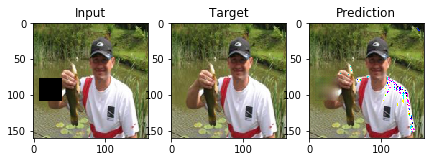

In [77]:
show_results(learn,figsize=(7,7))